$$\textbf{\Huge{Eigenworm Final}}$$
$$\textit{{Ben and Neta}}$$

# Q1   
### Find an embedding for the data that will separate the swimming and crawling worms.

In [2]:
import pandas as pd
import numpy as np
from preProcess_fun import preProcess,plot_embedding 
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
path=r"C:\Users\benia\VScodeprojects\Physical_Models\doi_10_5061_dryad_stqjq2c8p__v20240130\dryad"
data=preProcess(path,1,All=False)
movements = data['movement'].unique()


The first method try is PCA, it finds the eigenvectors of the covariance matrix of the data (Σ) and sorts them by their corresponding eigenvalues (𝜆). These eigenvectors represent the directions of maximum variance. The goal is to minimize the reconstruction error ($∥𝑋−𝑋_{\text{reconstructed}}∥^2$), where 𝑋 is the original data and $𝑋_{\text{reconstructed}}$ is the data represented in reduced dimensions using the selected eigenvectors. This minimization preserves the most important information in the data by maximizing the variance explained in each successive eigenvector.


In [3]:
# Drop non-numerical columns
df_numeric = data.select_dtypes(include=[np.number])

# Convert DataFrame to numpy array
M = df_numeric.values
# Subtract the mean
M = M - np.mean(M, axis=0)
# Compute the covariance matrix
cov_matrix = np.cov(M, rowvar=False)

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Get the first two eigenvectors
pca_1 = eigenvectors[:, 0]
pca_2 = eigenvectors[:, 1]
pca_3 = eigenvectors[:, 2]

# Project the data onto the first two eigenvectors
projected_data = df_numeric.dot(np.array([pca_1, pca_2,pca_3]).T)


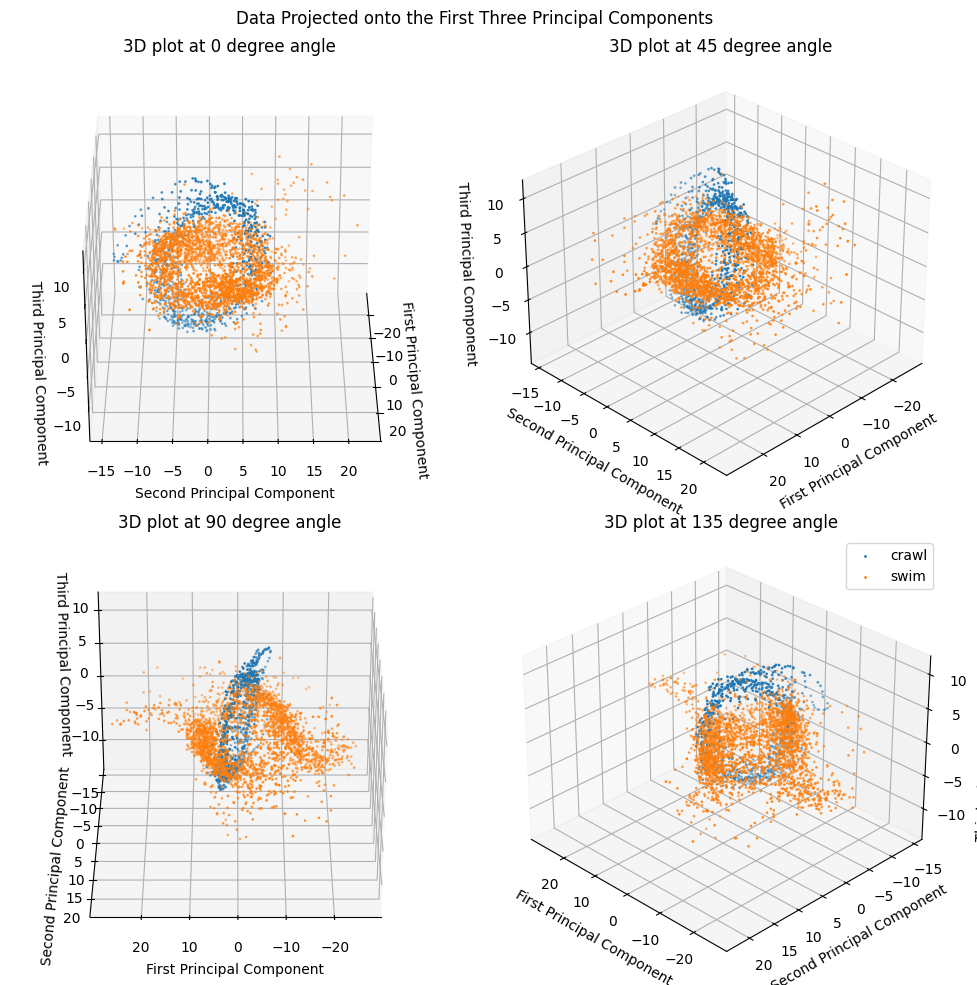

In [10]:
fig = plt.figure(figsize=(10, 10))

angles = [0, 45, 90, 135]

for i, angle in enumerate(angles, start=1):
    ax = fig.add_subplot(2, 2, i, projection='3d')
    for movement in movements:
        mask = data['movement'] == movement
        ax.scatter(projected_data[0][mask], projected_data[1][mask], projected_data[2][mask], label=movement, s=1)
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    ax.set_zlabel('Third Principal Component')
    ax.view_init(30, angle)
    ax.set_title(f'3D plot at {angle} degree angle')

plt.suptitle('Data Projected onto the First Three Principal Components')
plt.legend()
plt.tight_layout()
plt.show()

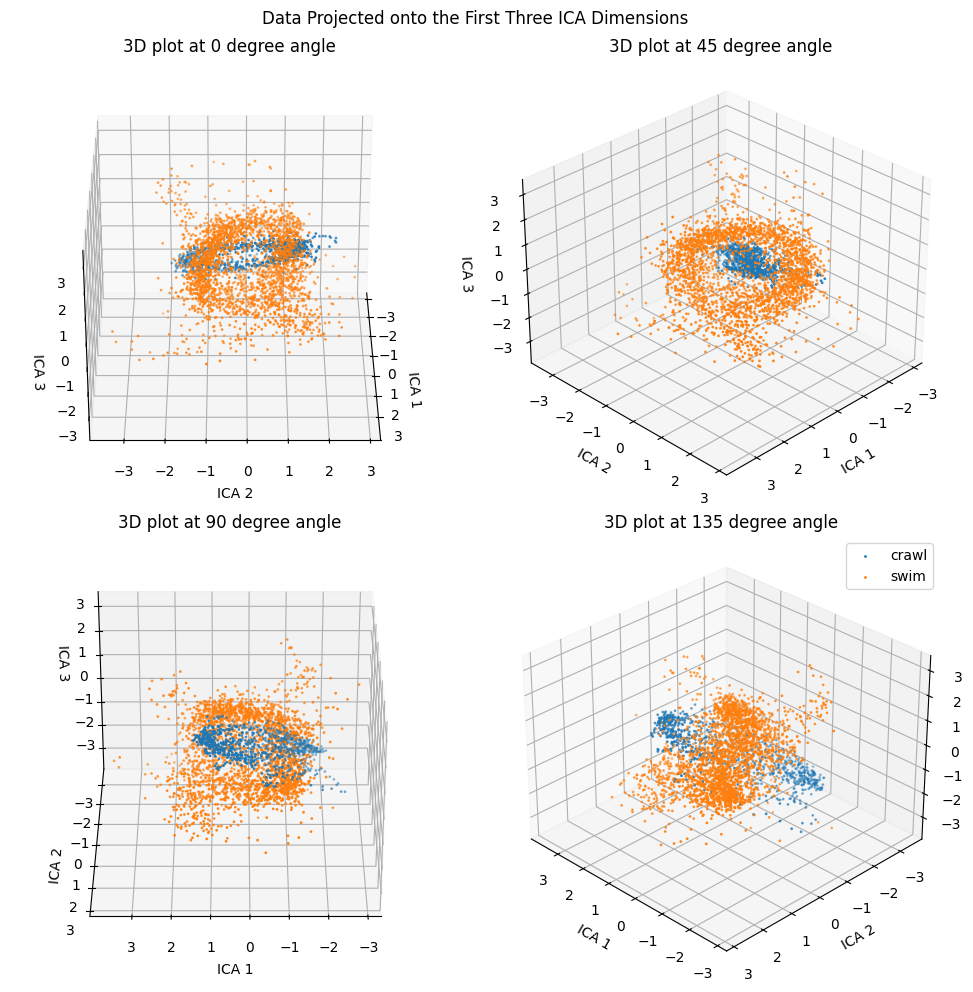

In [9]:
from sklearn.decomposition import FastICA

# Perform ICA dimensionality reduction
ica = FastICA(n_components=4, random_state=0)
ica_data = ica.fit_transform(df_numeric)

fig = plt.figure(figsize=(10, 10))

angles = [0, 45, 90, 135]

for i, angle in enumerate(angles, start=1):
    ax = fig.add_subplot(2, 2, i, projection='3d')
    for movement in movements:
        mask = data['movement'] == movement
        ax.scatter(ica_data[mask,0], ica_data[mask,1], ica_data[mask,2], label=movement, s=1)
    ax.set_xlabel('ICA 1')
    ax.set_ylabel('ICA 2')
    ax.set_zlabel('ICA 3')
    ax.view_init(30, angle)
    ax.set_title(f'3D plot at {angle} degree angle')

plt.suptitle('Data Projected onto the First Three ICA Dimensions')
plt.legend()
plt.tight_layout()
plt.show()



The next method we utilized is t-SNE, a non-linear dimensionality reduction technique that effectively embeds high-dimensional data into a lower-dimensional space by focusing on local data structures. It starts by converting Euclidean distances between data points into conditional probabilities that express pairwise similarities. t-SNE then optimizes the low-dimensional embedding to minimize the Kullback-Leibler divergence between the joint probability distributions 
$P$ in the high-dimensional space and 
$Q$ in the low-dimensional space, ensuring that similar data points remain close in the reduced space. Thus the obejctive function is:
$$\text{argmin}_{Y} \left( KL(P \parallel Q) = \sum_{i, j} p_{ij} \log \frac{p_{ij}}{q_{ij}} \right)$$

where $Y$ corresponds to the coordinates of a data point in this reduced space


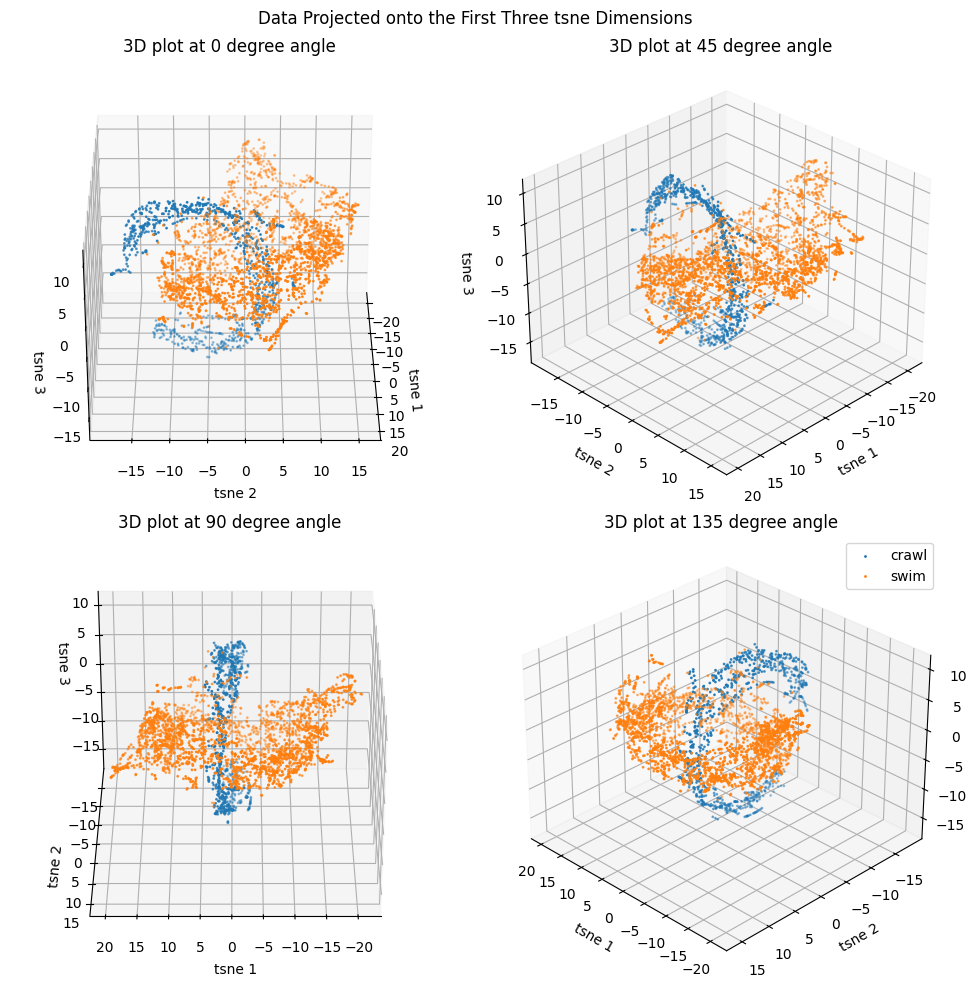

In [8]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=3)
tsne_embedding = tsne.fit_transform(df_numeric)
fig = plt.figure(figsize=(10, 10))

angles = [0, 45, 90, 135]

for i, angle in enumerate(angles, start=1):
    ax = fig.add_subplot(2, 2, i, projection='3d')
    for movement in movements:
        mask = data['movement'] == movement
        ax.scatter(tsne_embedding[mask,0], tsne_embedding[mask,1], tsne_embedding[mask,2], label=movement, s=1)
    ax.set_xlabel('tsne 1')
    ax.set_ylabel('tsne 2')
    ax.set_zlabel('tsne 3')
    ax.view_init(30, angle)
    ax.set_title(f'3D plot at {angle} degree angle')

plt.suptitle('Data Projected onto the First Three tsne Dimensions')
plt.legend()
plt.tight_layout()
plt.show()

The next method we utilized is Laplacian eigenmaps, that approximates a manifold upon which the data lies. It constructs a graph where each data point is a node and the edges represent the similarity between the data points. The Laplacian matrix is then constructed from this graph, and the eigenvectors of this matrix represent the embedding of the data points in a lower-dimensional space. The goal is to minimize the Laplacian operator of the data points in the reduced space,  the objective function is:

$$\text{argmin}_{Y} \left(\frac{1}{2}\sum_{ij}||y_i-y_j||W_{ij}\right)=\text{argmin}_{Y}\left( \text{Tr}(Y^TLY) \right)$$

where $Y$ corresponds to the coordinates of a data point in this reduced space. $L$ is the Laplacian matrix and $W$ is the weight matrix that represents the similarity between data points. If data points are not connected on the graph it means $W_{ij}=0$ hence when those points are distant in the embedding space theres no additional value to the sum, thus Laplacian eigenmaps only preseves the local structure of the data.  

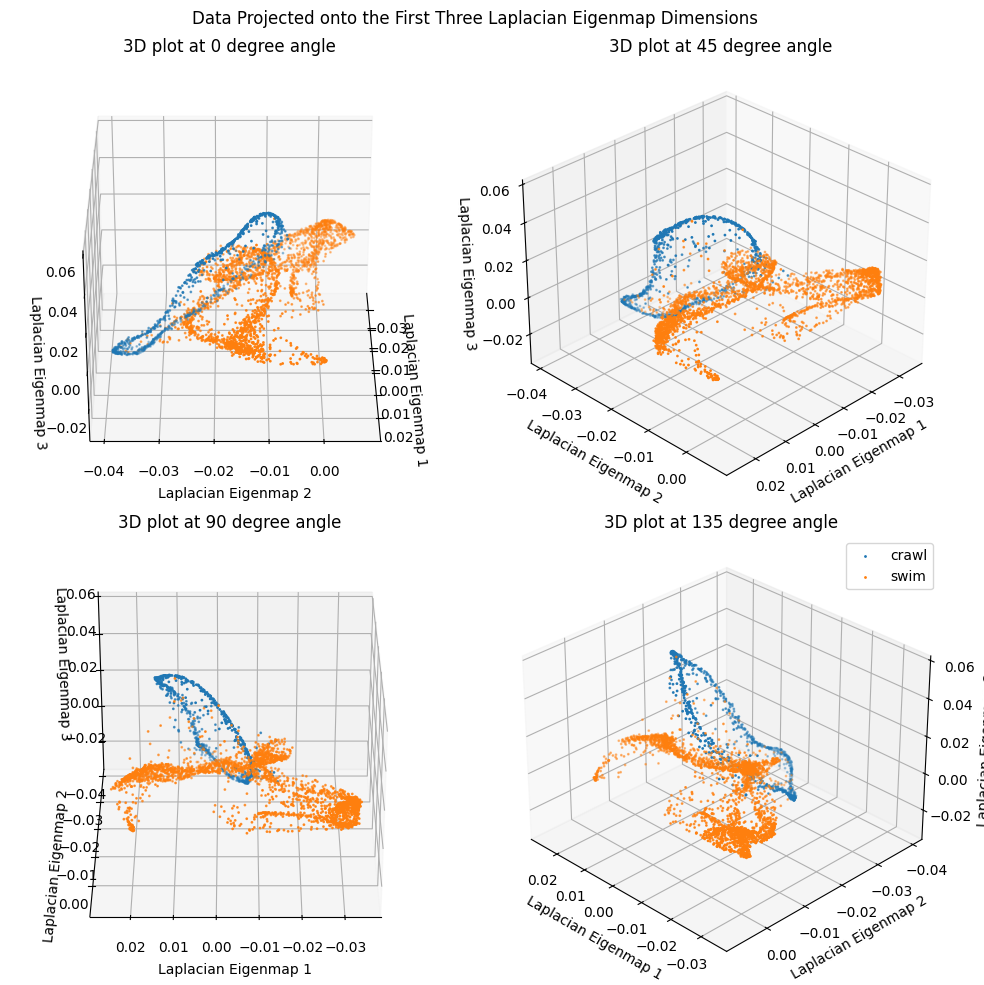

In [11]:
import numpy as np
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh
from mpl_toolkits.mplot3d import Axes3D

# Create a graph of nearest neighbors
n_neighbors = 100  # You can adjust this parameter
A = kneighbors_graph(df_numeric, n_neighbors, include_self=False)
A.data = np.exp(-A.data**2)
# Compute the degree matrix
D = diags(A.sum(axis=1).A1)

# Compute the Laplacian matrix
L = D - A

# Compute the eigenvalues and eigenvectors of the Laplacian matrix
Leigvals, Leigvecs = eigsh(L, k=6, which='SM')

L_embedding = Leigvecs[:, 0:4]

import numpy as np
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh
from mpl_toolkits.mplot3d import Axes3D

# Create a graph of nearest neighbors
n_neighbors = 100  # You can adjust this parameter
A = kneighbors_graph(df_numeric, n_neighbors, include_self=False)
A.data = np.exp(-A.data**2)
# Compute the degree matrix
D = diags(A.sum(axis=1).A1)

# Compute the Laplacian matrix
L = D - A

# Compute the eigenvalues and eigenvectors of the Laplacian matrix
Leigvals, Leigvecs = eigsh(L, k=6, which='SM')

L_embedding = Leigvecs[:, 0:4]

fig = plt.figure(figsize=(10, 10))

angles = [0, 45, 90, 135]

for i, angle in enumerate(angles, start=1):
    ax = fig.add_subplot(2, 2, i, projection='3d')
    for movement in movements:
        mask = data['movement'] == movement
        ax.scatter(L_embedding[mask,1], L_embedding[mask,2], L_embedding[mask,3], label=movement, s=1)
    ax.set_xlabel('Laplacian Eigenmap 1')
    ax.set_ylabel('Laplacian Eigenmap 2')
    ax.set_zlabel('Laplacian Eigenmap 3')
    ax.view_init(30, angle)
    ax.set_title(f'3D plot at {angle} degree angle')

plt.suptitle('Data Projected onto the First Three Laplacian Eigenmap Dimensions')
plt.legend()
plt.tight_layout()
plt.show()


The last method we use is diffusion maps. It constructs a Markov matrix from the data points, where each row represents the probability distribution of transitioning from one data point to another. Since we take the power of the Markov matrix, it represents the probability distribution of transitioning from one data point to another after a certain number of steps. Hence the globally important data points (or the central nodes) are emphasized in the embedding space. 

In [33]:

from scipy.spatial.distance import pdist, squareform
from scipy.sparse import csr_matrix, diags

# Step 1: Compute the pairwise distance matrix
dist_matrix = csr_matrix(squareform(pdist(df_numeric)))

# Step 2: Compute the kernel matrix
sigma = np.median(dist_matrix.data)  # This is a common choice for the kernel bandwidth
dist_matrix.data = np.exp(-dist_matrix.data ** 2 / (2 * sigma ** 2))

# Step 3: Normalize the kernel matrix to get the transition matrix
row_sums = np.array(dist_matrix.sum(axis=1)).ravel()
transition_matrix = diags(1 / row_sums).dot(dist_matrix)

# Step 4: Compute the eigenvalues and eigenvectors of the transition matrix
Aeigvals, Aeigvecs = eigsh(transition_matrix**3, k=6, which='LM')

# Step 5: The diffusion map is given by the eigenvectors scaled by the corresponding eigenvalues
diffusion_map = Aeigvecs * Aeigvals


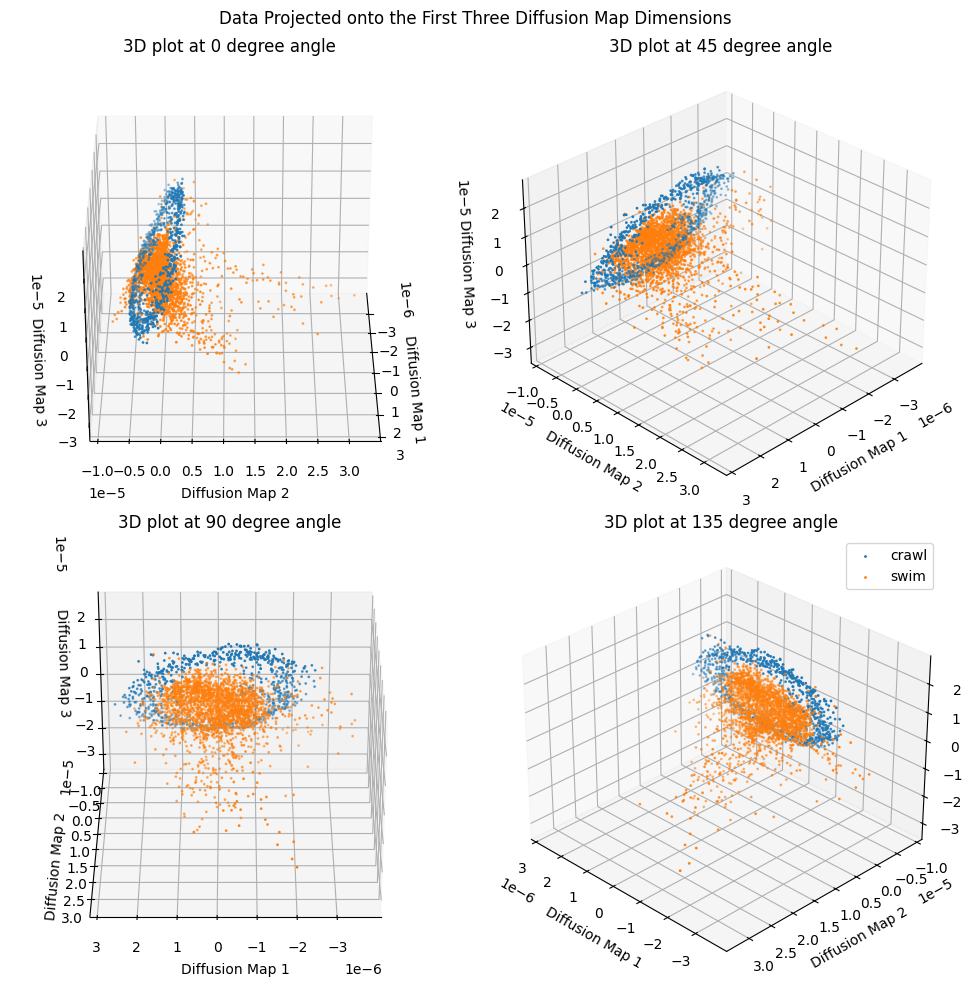

In [34]:
fig = plt.figure(figsize=(10, 10))

angles = [0, 45, 90, 135]

for i, angle in enumerate(angles, start=1):
    ax = fig.add_subplot(2, 2, i, projection='3d')
    for movement in movements:
        mask = data['movement'] == movement
        ax.scatter(diffusion_map[mask,0], diffusion_map[mask,1], diffusion_map[mask,2], label=movement, s=1)
    ax.set_xlabel('Diffusion Map 1')
    ax.set_ylabel('Diffusion Map 2')
    ax.set_zlabel('Diffusion Map 3')
    ax.view_init(30, angle)
    ax.set_title(f'3D plot at {angle} degree angle')

plt.suptitle('Data Projected onto the First Three Diffusion Map Dimensions')
plt.legend()
plt.tight_layout()
plt.show()

# Q2  a) 

### Quantify how the embeddings from the different methods compare ?

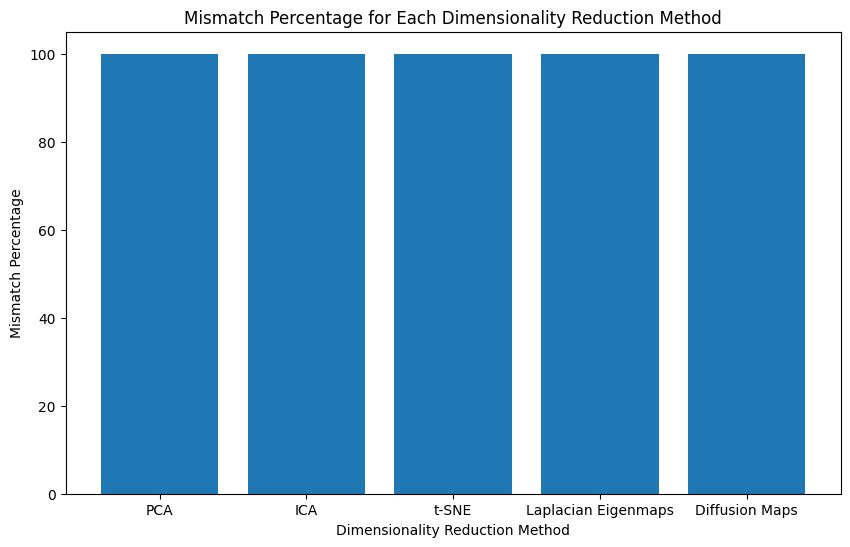

In [24]:
from sklearn.cluster import KMeans

# Define a function for KMeans clustering
def perform_kmeans(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(data)
    return kmeans.labels_

# Define the number of clusters
n_clusters = 2

# Get true labels from the DataFrame
true_labels = data['movement'].values

# Initialize lists to store mismatch percentages
mismatch_percentages = []

# Iterate through each dimensionality reduction method
methods = ["PCA", "ICA", "t-SNE", "Laplacian Eigenmaps", "Diffusion Maps"]
for method, reduced_data in zip(methods, [projected_data, ica_data[:,0:3], tsne_embedding[:,0:3], L_embedding[:,0:3], diffusion_map[:,0:3]]):
    # Perform KMeans clustering
    clusters = perform_kmeans(reduced_data, n_clusters)
    # Calculate the percentage of mismatched labels
    mismatch_percentage = (clusters != true_labels).mean() * 100
    mismatch_percentages.append(mismatch_percentage)

# Plot the number of mismatches for each method
plt.figure(figsize=(10, 6))
plt.bar(methods, mismatch_percentages)
plt.xlabel('Dimensionality Reduction Method')
plt.ylabel('Mismatch Percentage')
plt.title('Mismatch Percentage for Each Dimensionality Reduction Method')
plt.show()


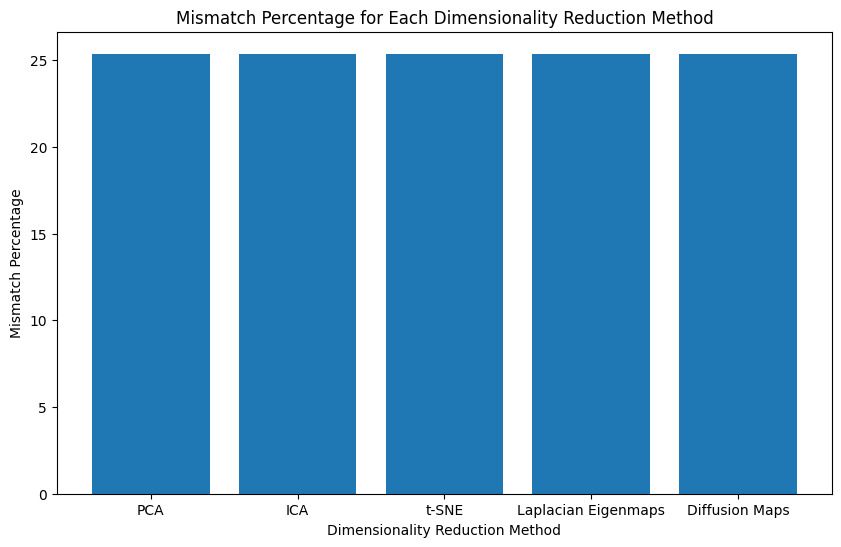

In [32]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
def assign_cluster_labels(clusters, true_labels):
    cluster_labels = np.empty_like(clusters)
    for cluster in np.unique(clusters):
        mask = clusters == cluster
        majority_class = np.argmax(np.bincount(true_labels[mask]))
        cluster_labels[mask] = majority_class
    return cluster_labels


# Define a function for KMeans clustering
def perform_kmeans(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(data)
    return kmeans.labels_

# Define the number of clusters
n_clusters = 2

# Get true labels from the DataFrame
true_labels = data['movement'].values

# Initialize lists to store mismatch percentages
mismatch_percentages = []

# Convert true labels to numeric format if needed
true_labels_numeric = LabelEncoder().fit_transform(true_labels)

# Iterate through each dimensionality reduction method
for method, reduced_data in zip(methods, [projected_data, ica_data[:,0:3], tsne_embedding[:,0:3], L_embedding[:,0:3], diffusion_map[:,0:3]]):
    # Perform KMeans clustering
    clusters = perform_kmeans(reduced_data, n_clusters)
    
    # Assign cluster labels based on majority class
    cluster_labels = assign_cluster_labels(clusters, true_labels_numeric)
    
    # Calculate the percentage of mismatched labels
    mismatch_percentage = (cluster_labels != true_labels_numeric).mean() * 100
    mismatch_percentages.append(mismatch_percentage)


# Plot the number of mismatches for each method
plt.figure(figsize=(10, 6))
plt.bar(methods, mismatch_percentages)
plt.xlabel('Dimensionality Reduction Method')
plt.ylabel('Mismatch Percentage')
plt.title('Mismatch Percentage for Each Dimensionality Reduction Method')
plt.show()


# Q2  b)
### What do you think about the debate regarding if crawling and swimming are two separate gaits 

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define KMeans
kmeans = KMeans(n_clusters=2, random_state=0)

# Fit the model to the ICA data
kmeans.fit(ica_data[:,0:3])

# Get the cluster assignments
clusters = kmeans.labels_

# Define cluster names
cluster_names = {0: 'swim', 1: 'crawl'}

# Map cluster labels to names
cluster_labels = [cluster_names[label] for label in clusters]

# Create a DataFrame with the true and predicted labels
df_labels = pd.DataFrame({'true': df['type'], 'predicted': cluster_labels})

# Find the percentage of mismatched labels
mismatched = df_labels[df_labels['true'] != df_labels['predicted']]
mismatch_percentage = len(mismatched) / len(df_labels) * 100

print(f'The percentage of mismatched labels is {mismatch_percentage:.2f}%')

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original ICA data in the first subplot
for type in types:
    mask = df['type'] == type
    ax[0].scatter(ica_data[mask, 0], ica_data[mask, 1], label=type)

ax[0].set_xlabel('ICA 1')
ax[0].set_ylabel('ICA 2')
ax[0].set_title('Original ICA Data')
ax[0].legend()

# Plot the labeled data in the second subplot
for cluster in range(2):
    mask = clusters == cluster
    ax[1].scatter(ica_data[mask, 0], ica_data[mask, 1], label=f'Cluster {cluster}')

ax[1].set_xlabel('ICA 1')
ax[1].set_ylabel('ICA 2')
ax[1].set_title('Labeled ICA Data')
ax[1].legend()

plt.show()



In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

# Define KMeans
kmeans = KMeans(n_clusters=2, random_state=0)
# Fit the model to the embedding
kmeans.fit(embedding)

# Get the cluster assignments
clusters = kmeans.labels_

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original embedding in the first subplot
for type in types:
    mask = df['type'] == type
    ax[0].scatter(embedding[mask, 0], embedding[mask, 1], label=type)

ax[0].set_xlabel('Embedding 1')
ax[0].set_ylabel('Embedding 2')
ax[0].set_title('Original Laplacian Eigenmap Embedding')
ax[0].legend()

# Plot the labeled data in the second subplot
for cluster in range(2):
    mask = clusters == cluster
    ax[1].scatter(embedding[mask, 0], embedding[mask, 1], label=f'Cluster {cluster}')

ax[1].set_xlabel('Embedding 1')
ax[1].set_ylabel('Embedding 2')
ax[1].set_title('Labeled Laplacian Eigenmap Embedding')
ax[1].legend()

plt.show()

# Define cluster names
cluster_names = {0: 'swim', 1: 'crawl'}

# Map cluster labels to names
cluster_labels = [cluster_names[label] for label in clusters]

# Create a DataFrame with the true and predicted labels
df_labels = pd.DataFrame({'true': df['type'], 'predicted': cluster_labels})

# Find the percentage of mismatched labels
mismatched = df_labels[df_labels['true'] != df_labels['predicted']]
mismatch_percentage = len(mismatched) / len(df_labels) * 100

print(f'The percentage of mismatched labels is {mismatch_percentage:.2f}%')

The percentage of mismatched labels is 53.26%
